<a href="https://colab.research.google.com/github/haricharan123461/Sentiment-GenAI/blob/main/Sentiment%2BGenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AUDIO PART

In [ ]:
########AUDIO PART###########

In [ ]:
pip install SpeechRecognition pydub chardet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 11.9 MB/s eta 0:00:00


In [ ]:
#Read input files
import base64
import csv

# List of WAV files
wavfiles = [ "/content/1.wav" ]

# Create CSV file to store file paths
csv_filename = "csvout.csv"

with open(csv_filename, 'w', newline='') as fileout:
    writer = csv.writer(fileout)
    writer.writerow(["Audio File"])  # Write header
    for wav in wavfiles:
        writer.writerow([wav])

print(f"WAV file paths saved to {csv_filename}")


WAV file paths saved to csvout.csv


In [ ]:
#processing part of speech to text
import speech_recognition as sr
import os
import csv
import sys
import chardet
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Increase CSV field size limit to prevent errors
maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

# Create a speech recognition object
r = sr.Recognizer()

# Function to transcribe a single audio file
def transcribe_audio(path):
    with sr.AudioFile(path) as source:
        audio_listened = r.record(source)
        try:
            text = r.recognize_google(audio_listened)
        except sr.UnknownValueError:
            text = "[Unrecognized Audio]"
    return text

# Function to split large audio files into chunks and transcribe them
def get_large_audio_transcription_on_silence(path):
    sound = AudioSegment.from_file(path)
    chunks = split_on_silence(sound,
        min_silence_len=500,
        silence_thresh=sound.dBFS-14,
        keep_silence=500,
    )

    folder_name = "audio-chunks"
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)

    whole_text = ""
    for i, audio_chunk in enumerate(chunks, start=1):
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        try:
            text = transcribe_audio(chunk_filename)
        except sr.UnknownValueError:
            text = "[Unrecognized Audio]"
        else:
            text = f"{text.capitalize()}. "
            print(chunk_filename, ":", text)
            whole_text += text

    return whole_text


In [ ]:
# Function to process CSV input and generate transcriptions
def process_csv(input_csv, output_csv):
    # Detect file encoding
    with open(input_csv, 'rb') as rawdata:
        result = chardet.detect(rawdata.read())
    file_encoding = result['encoding']

    with open(input_csv, newline='', encoding=file_encoding) as csvfile:
        reader = csv.reader(csvfile)
        next(reader, None)  # Skip header
        audio_files = [row[0] for row in reader]

    transcriptions = []
    for audio_path in audio_files:
        if os.path.exists(audio_path):
            print(f"Processing: {audio_path}")
            transcription = get_large_audio_transcription_on_silence(audio_path)
        else:
            transcription = "[File Not Found]"
        transcriptions.append([audio_path, transcription])

    # Save transcriptions to CSV
    with open(output_csv, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Audio File", "Transcription"])
        writer.writerows(transcriptions)

# Process the CSV and generate transcriptions
input_csv = "csvout.csv"
output_csv = "transcriptions.csv"
process_csv(input_csv, output_csv)

print(f"Transcriptions saved to {output_csv}")


Processing: /content/1.wav
audio-chunks/chunk1.wav : 5 amazon finds that really makes sense. 
audio-chunks/chunk2.wav : This grass braided laundry basket will make housing dirty laundry so pretty and comes with a washable in a lining this is an adjustable. 
Transcriptions saved to transcriptions.csv


# Text Processing, Ratings and Emojis

In [ ]:
#DATASET PREPROCESSING

In [ ]:
pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from emoji import demojize

# Download required NLTK resources (only needs to be run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For lemmatization context

# Load dataset
file_path = "dataset.csv"
df = pd.read_csv(file_path, encoding="utf-8")

# Display initial dataset
print("\U0001F4C1 Initial Data:\n", df.head())

# Step 1: Handle missing values
df.dropna(subset=['Review Text', 'Title', 'Ratings'], inplace=True)
df.fillna("", inplace=True)

# Step 2: Remove duplicates
df.drop_duplicates(subset=['Review Text'], keep='first', inplace=True)

# Preprocessing functions
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Convert emojis to words
    text = demojize(text, delimiters=(" ", " "))
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove numbers and punctuation
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stopwords.words('english') and len(word) > 2]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Apply preprocessing
df['Cleaned Review'] = df['Review Text'].apply(preprocess_text)
df['Cleaned Title'] = df['Title'].apply(preprocess_text)

# Convert ratings to sentiment
def categorize_rating(rating):
    try:
        rating = float(rating)
        if rating >= 4:
            return 'Positive'
        elif rating == 3:
            return 'Neutral'
        else:
            return 'Negative'
    except:
        return 'Unknown'

df['Sentiment'] = df['Ratings'].apply(categorize_rating)

# Display processed data
print("\n\U0001F4C1 Processed Data:\n", df[['ID', 'Cleaned Review', 'Cleaned Title', 'Ratings', 'Sentiment']].head())

# Save to CSV
df.to_csv("cleaned_dataset.csv", index=False)
print("\n✅ Data preprocessing complete! Cleaned data saved as 'cleaned_dataset.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


📁 Initial Data:
    Unnamed: 0    ID  Age                    Title  \
0           0   767   33                      NaN   
1           1  1080   34                      NaN   
2           2  1077   60  Some major design flaws   
3           3  1049   50         My favorite buy!   
4           4   847   47         Flattering shirt   

                                         Review Text  Ratings  \
0  Absolutely wonderful - silky and sexy and comf...        4   
1  Love this dress!  it's sooo pretty.  i happene...        5   
2  I had such high hopes for this dress and reall...        3   
3  I love, love, love this jumpsuit. it's fun, fl...        5   
4  This shirt is very flattering to all due to th...        5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                  

In [ ]:
#Feature Extraction for Sentiment Analysis

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the cleaned dataset
try:
    df = pd.read_csv("cleaned_dataset.csv")
    print("📂 Loaded 'cleaned_dataset.csv' successfully.")
except FileNotFoundError:
    print("❌ Error: 'cleaned_dataset.csv' not found.")
    exit()

# Check required columns
if 'Cleaned Review' not in df.columns or 'Ratings' not in df.columns:
    print("❌ Error: Required columns 'Cleaned Review' or 'Ratings' missing.")
    exit()

# Drop missing or empty reviews just in case
df = df[df['Cleaned Review'].notna() & df['Cleaned Review'].str.strip().astype(bool)]

# Calculate average review length (in words)
avg_review_length = df['Cleaned Review'].apply(lambda x: len(str(x).split())).mean()
print(f"📏 Average Review Length: {avg_review_length:.2f} words")

# Choose vectorizer based on review length
if avg_review_length > 50:
    print("🔍 Using TF-IDF Vectorizer (reviews are long)...")
    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),          # Capture unigrams and bigrams
        stop_words='english',        # Built-in stopword removal
        sublinear_tf=True            # Better normalization
    )
else:
    print("🔍 Using CountVectorizer (Bag of Words for short reviews)...")
    vectorizer = CountVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english'
    )

# Fit and transform the 'Cleaned Review' column
X_features = vectorizer.fit_transform(df['Cleaned Review'])

# Convert to DataFrame
features_df = pd.DataFrame(X_features.toarray(), columns=vectorizer.get_feature_names_out())

# Add Ratings column for sentiment labels
features_df['Ratings'] = df['Ratings']

# Optional: Convert Ratings to numeric labels (if you want to use for ML later)
label_encoder = LabelEncoder()
features_df['Sentiment_Label'] = label_encoder.fit_transform(df['Ratings'])

# Save to CSV
output_file = "bow_tfidf_features_with_ratings.csv"
features_df.to_csv(output_file, index=False)

print(f"\n✅ Feature extraction complete! File saved as: '{output_file}'")


📂 Loaded 'cleaned_dataset.csv' successfully.
📏 Average Review Length: 28.92 words
🔍 Using CountVectorizer (Bag of Words for short reviews)...

✅ Feature extraction complete! File saved as: 'bow_tfidf_features_with_ratings.csv'


In [ ]:
df = pd.read_csv("bow&tf-idf_features_with_ratings.csv")
print(df.columns)

Index(['aa', 'ab', 'abdomen', 'ability', 'able', 'about', 'above', 'absolute',
       'absolutely', 'abstract',
       ...
       'zip', 'zipped', 'zipper', 'zippered', 'zippers', 'zipping', 'zips',
       'zone', 'zoom', 'Ratings'],
      dtype='object', length=5001)


In [ ]:
#Model Training & Evaluation

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Load the feature dataset
df = pd.read_csv("bow_tfidf_features_with_ratings.csv")
print("📂 Loaded 'bow_tfidf_features_with_ratings.csv' successfully.")

# Step 1: Convert Ratings to Sentiment
def categorize_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Ratings'].apply(categorize_rating)

# Step 2: Encode Sentiment
label_encoder = LabelEncoder()
df['SentimentEncoded'] = label_encoder.fit_transform(df['Sentiment'])

# Step 3: Extract Features and Labels
X = df.drop(columns=['Ratings', 'Sentiment', 'SentimentEncoded'])
y = df['SentimentEncoded']

# Step 4: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 5: Train Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB(),
}

model_performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_performance[name] = f1

    print(f"\n🔹 Model: {name}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"📊 Weighted F1-Score: {f1:.4f}")
    print("📌 Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("📌 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 6: Save Best Model and Label Encoder
best_model_name = max(model_performance, key=model_performance.get)
best_model = models[best_model_name]

with open("best_sentiment_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(label_encoder, le_file)

print(f"\n✅ Best model '{best_model_name}' saved as 'best_sentiment_model.pkl'")
print("✅ Label encoder saved as 'label_encoder.pkl'")

# OPTIONAL: Save a new vectorizer for future text inference
# Recreate and fit vectorizer on actual cleaned text
try:
    original_df = pd.read_csv("cleaned_dataset.csv")
    print("📂 Loaded 'cleaned_dataset.csv' to fit vectorizer.")
except FileNotFoundError:
    print("❌ Error: 'cleaned_dataset.csv' not found. Skipping vectorizer save.")
    exit()

# Check text length
avg_review_length = original_df['Cleaned Review'].apply(lambda x: len(str(x).split())).mean()

if avg_review_length > 50:
    print("🔍 Using TF-IDF Vectorizer for saving...")
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', sublinear_tf=True)
else:
    print("🔍 Using CountVectorizer for saving...")
    vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

vectorizer.fit(original_df['Cleaned Review'])

# Save vectorizer
with open("vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

print("✅ Vectorizer saved as 'vectorizer.pkl'")


📂 Loaded 'bow_tfidf_features_with_ratings.csv' successfully.

🔹 Model: Logistic Regression
✅ Accuracy: 0.8073
📊 Weighted F1-Score: 0.7964
📌 Classification Report:
               precision    recall  f1-score   support

    Negative       0.52      0.49      0.50       410
     Neutral       0.39      0.28      0.33       493
    Positive       0.89      0.94      0.91      3031

    accuracy                           0.81      3934
   macro avg       0.60      0.57      0.58      3934
weighted avg       0.79      0.81      0.80      3934

📌 Confusion Matrix:
 [[ 202  102  106]
 [ 112  139  242]
 [  78  118 2835]]

🔹 Model: Naïve Bayes
✅ Accuracy: 0.8119
📊 Weighted F1-Score: 0.8140
📌 Classification Report:
               precision    recall  f1-score   support

    Negative       0.54      0.51      0.53       410
     Neutral       0.41      0.45      0.43       493
    Positive       0.92      0.91      0.92      3031

    accuracy                           0.81      3934
   macro avg

In [ ]:
#New_Review

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the trained model
with open("best_sentiment_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Load the vectorizer used during training
with open("vectorizer.pkl", "rb") as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

# Initialize VADER Sentiment Analyzer
vader = SentimentIntensityAnalyzer()

def predict_vader_sentiment(review):
    """Predict sentiment using VADER."""
    score = vader.polarity_scores(review)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def predict_model_sentiment(review):
    """Predict sentiment using trained model."""
    review_vectorized = vectorizer.transform([review])  # Transform input text
    prediction = model.predict(review_vectorized)[0]

    sentiment_mapping = {2: "Positive", 1: "Neutral", 0: "Negative", -1: "Negative"}
    return sentiment_mapping.get(prediction, "Unknown")

# Example review
new_review = "The zipper broke on this piece the first time i wore it. very disappointing since i love the design. i'm actually going to try to replace the zipper myself with something stronger, but annoying that it's come to that."

# VADER Prediction
vader_sentiment = predict_vader_sentiment(new_review)


print(f"🔹 VADER Sentiment: {vader_sentiment}")


🔹 VADER Sentiment: Negative


In [ ]:
#Sentiment Scoring & Interpretation

In [ ]:
pip install transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
from transformers import pipeline

# Load the dataset
df = pd.read_csv("cleaned_dataset.csv")

# Ensure required column exists
if 'Cleaned Review' not in df.columns:
    print("❌ Error: 'Cleaned Review' column not found in dataset.")
    exit()

# Drop old ML prediction column if it exists
if 'ML Model Sentiment' in df.columns:
    df.drop(columns=['ML Model Sentiment'], inplace=True)

# Load BERT sentiment analysis pipeline
print("🔄 Loading BERT sentiment analysis model...")
classifier = pipeline("sentiment-analysis")

# Apply sentiment prediction
print("🔍 Predicting sentiment...")
df['BERT Sentiment'] = df['Cleaned Review'].apply(lambda x: classifier(x[:512])[0]['label'])

# Optional: Standardize labels (e.g., POSITIVE → Positive)
df['BERT Sentiment'] = df['BERT Sentiment'].str.capitalize()

# Save results
df.to_csv("sentiment_predictions.csv", index=False)
print("✅ Sentiment analysis complete using BERT! Saved as 'sentiment_predictions.csv'")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


🔄 Loading BERT sentiment analysis model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


🔍 Predicting sentiment...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Sentiment analysis complete using BERT! Saved as 'bert_sentiment_predictions.csv'


In [ ]:
#Visualization & Reporting

<ipython-input-15-67636c9d3d30>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Sentiment", palette="coolwarm", order=["Negative", "Neutral", "Positive"])


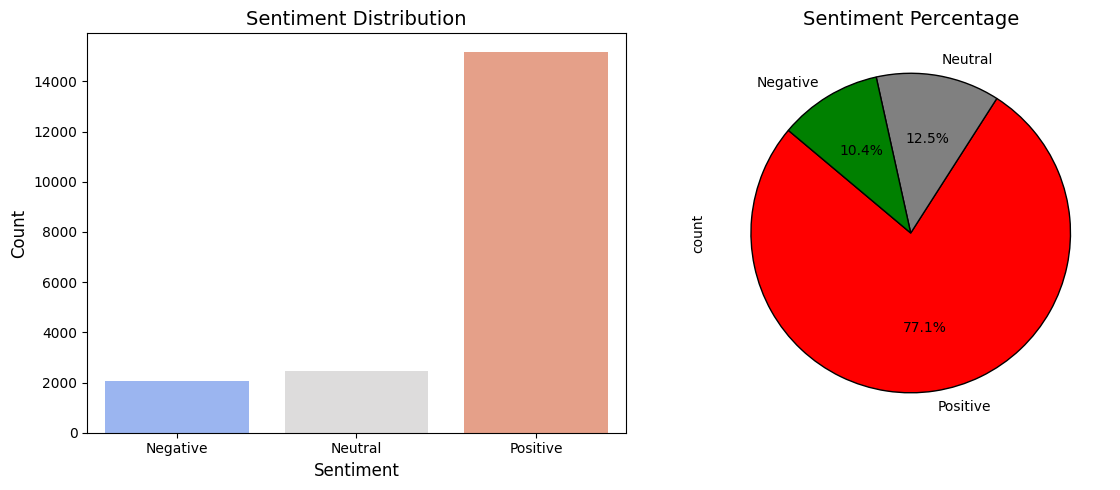

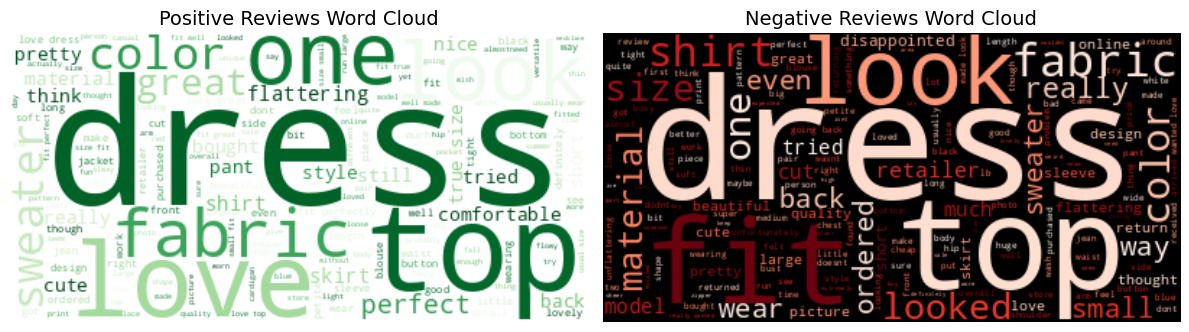

<ipython-input-15-67636c9d3d30>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_pos_words.values()), y=list(top_pos_words.keys()), palette="Greens_r")
<ipython-input-15-67636c9d3d30>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_neg_words.values()), y=list(top_neg_words.keys()), palette="Reds_r")


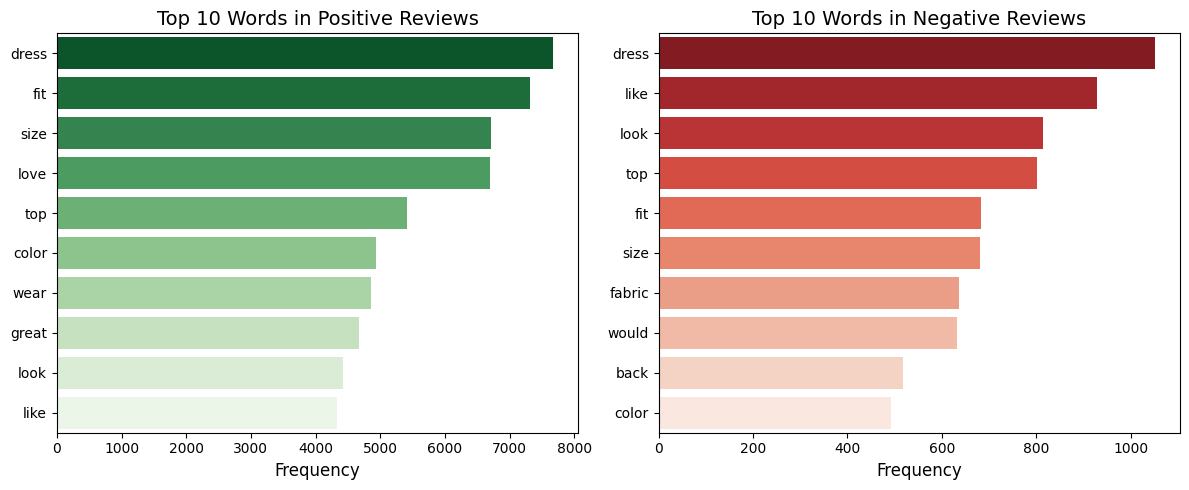


📊 **Sentiment Analysis Report:**
✅ Positive Reviews: 77.05%
⚖️ Neutral Reviews: 12.53%
❌ Negative Reviews: 10.42%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# Load the dataset with sentiment scores
df = pd.read_csv("sentiment_predictions.csv")

# Handle missing values
df.dropna(subset=["Sentiment", "Cleaned Review"], inplace=True)

### 📌 1. Sentiment Distribution (Bar Chart & Pie Chart) ###
plt.figure(figsize=(12, 5))

# Bar Chart
plt.subplot(1, 2, 1)
sns.countplot(data=df, x="Sentiment", palette="coolwarm", order=["Negative", "Neutral", "Positive"])
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Pie Chart
plt.subplot(1, 2, 2)
df["Sentiment"].value_counts().plot.pie(
    autopct="%1.1f%%", colors=["red", "gray", "green"], startangle=140, wedgeprops={"edgecolor": "black"}
)
plt.title("Sentiment Percentage", fontsize=14)

plt.tight_layout()
plt.show()

### 📌 2. Word Cloud for Positive & Negative Reviews ###
positive_text = " ".join(df[df["Sentiment"] == "Positive"]["Cleaned Review"])
negative_text = " ".join(df[df["Sentiment"] == "Negative"]["Cleaned Review"])

plt.figure(figsize=(12, 5))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=200, background_color="white", colormap="Greens").generate(positive_text)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud", fontsize=14)

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=200, background_color="black", colormap="Reds").generate(negative_text)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud", fontsize=14)

plt.tight_layout()
plt.show()

### 📌 3. Most Frequent Words in Reviews ###
positive_words = Counter(positive_text.split())
negative_words = Counter(negative_text.split())

# Extract top 10 words for each sentiment
top_pos_words = dict(positive_words.most_common(10))
top_neg_words = dict(negative_words.most_common(10))

# Create a bar plot for word frequencies
plt.figure(figsize=(12, 5))

# Positive Words
plt.subplot(1, 2, 1)
sns.barplot(x=list(top_pos_words.values()), y=list(top_pos_words.keys()), palette="Greens_r")
plt.title("Top 10 Words in Positive Reviews", fontsize=14)
plt.xlabel("Frequency", fontsize=12)

# Negative Words
plt.subplot(1, 2, 2)
sns.barplot(x=list(top_neg_words.values()), y=list(top_neg_words.keys()), palette="Reds_r")
plt.title("Top 10 Words in Negative Reviews", fontsize=14)
plt.xlabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

### 📌 4. Reporting Summary ###
report = df["Sentiment"].value_counts(normalize=True) * 100
print("\n📊 **Sentiment Analysis Report:**")
print(f"✅ Positive Reviews: {report.get('Positive', 0):.2f}%")
print(f"⚖️ Neutral Reviews: {report.get('Neutral', 0):.2f}%")
print(f"❌ Negative Reviews: {report.get('Negative', 0):.2f}%")

[Info] Analyzing Sentiment for ID: 1077

         ID                                        Review Text Sentiment
0      1077  I had such high hopes for this dress and reall...   Neutral
6      1077  I love this dress. i usually get an xs but it ...  Positive
7      1077  I'm 5"5' and 125 lbs. i ordered the s petite t...  Positive
8      1077  Dress runs small esp where the zipper area run...   Neutral
11     1077  This is a nice choice for holiday gatherings. ...   Neutral
...     ...                                                ...       ...
18675  1077  Love this dress! very flattering. material is ...  Positive
18678  1077  Thought this would be great for a laid-back we...  Negative
18679  1077  I  absolutely fell in love with the stress whe...   Neutral
18684  1077  This dress is gorgeous. i bought it to wear to...  Positive
18685  1077  A truly gorgeous dress. ran a little too small...  Positive

[251 rows x 3 columns]
[Warning] Sentiment score columns not found. Skipping visua

<Figure size 600x400 with 0 Axes>

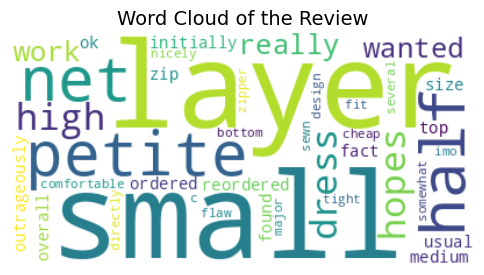

<ipython-input-32-bb23ed67a3bc>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="Blues_r")


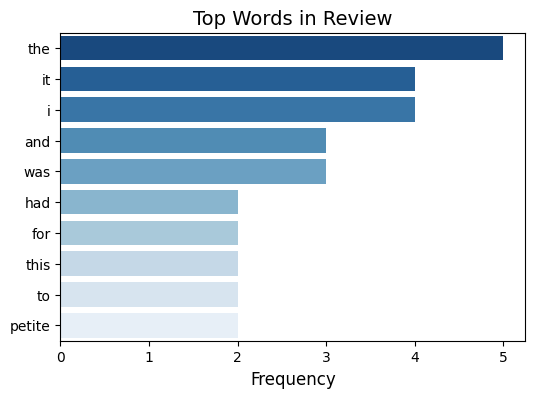


[Info] Sentiment for ID 1077: Neutral


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load the dataset
df = pd.read_csv("sentiment_predictions.csv")

# Input: Select an ID for analysis
selected_id = 1077  # Change this to the desired ID

# Filter the dataset for the specific ID
df_single = df[df["ID"] == selected_id]

# Check if the ID exists
if df_single.empty:
    print(f"[Error] No data found for ID: {selected_id}")
else:
    print(f"[Info] Analyzing Sentiment for ID: {selected_id}\n")

    # Print only available columns
    available_columns = df_single.columns.intersection(["ID", "Review Text", "Sentiment", "Negative Score", "Neutral Score", "Positive Score"])
    print(df_single[available_columns.tolist()])

    ### Sentiment Score Visualization ###
    plt.figure(figsize=(6, 4))

    # Check if sentiment score columns exist
    score_columns = ["Negative Score", "Neutral Score", "Positive Score"]
    if all(col in df_single.columns for col in score_columns):
        scores = df_single.iloc[0][score_columns].values
        labels = score_columns
        colors = ["red", "gray", "green"]

        plt.bar(labels, scores, color=colors)
        plt.title(f"Sentiment Score for ID: {selected_id}", fontsize=14)
        plt.ylabel("Score")
        plt.show()
    else:
        print("[Warning] Sentiment score columns not found. Skipping visualization.")

    ### Word Cloud for Single Review ###
    review_text = df_single["Review Text"].values[0] if "Review Text" in df_single.columns and not df_single["Review Text"].isna().values[0] else ""

    if review_text:
        plt.figure(figsize=(6, 4))
        wordcloud = WordCloud(width=400, height=200, background_color="white").generate(review_text.lower())
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud of the Review", fontsize=14)
        plt.show()
    else:
        print("[Warning] No review text available for word cloud.")

    ### Most Frequent Words ###
    if review_text:
        words = Counter(review_text.split())
        top_words = dict(words.most_common(10))

        plt.figure(figsize=(6, 4))
        sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="Blues_r")
        plt.title("Top Words in Review", fontsize=14)
        plt.xlabel("Frequency", fontsize=12)
        plt.show()
    else:
        print("[Warning] No review text available for word frequency analysis.")

    ### Sentiment Summary ###
    sentiment = df_single["Sentiment"].values[0] if "Sentiment" in df_single.columns else "Unknown"
    print(f"\n[Info] Sentiment for ID {selected_id}: {sentiment}")


In [ ]:
#Similar Reviews(Unique)

[Info] Analyzing Sentiment for ID: 1077

         ID                                        Review Text Sentiment
0      1077  I had such high hopes for this dress and reall...   Neutral
6      1077  I love this dress. i usually get an xs but it ...  Positive
7      1077  I'm 5"5' and 125 lbs. i ordered the s petite t...  Positive
8      1077  Dress runs small esp where the zipper area run...   Neutral
11     1077  This is a nice choice for holiday gatherings. ...   Neutral
...     ...                                                ...       ...
18675  1077  Love this dress! very flattering. material is ...  Positive
18678  1077  Thought this would be great for a laid-back we...  Negative
18679  1077  I  absolutely fell in love with the stress whe...   Neutral
18684  1077  This dress is gorgeous. i bought it to wear to...  Positive
18685  1077  A truly gorgeous dress. ran a little too small...  Positive

[251 rows x 3 columns]

[Info] Top 20 Unique Reviews:
1. I had such high hopes for

<Figure size 600x400 with 0 Axes>

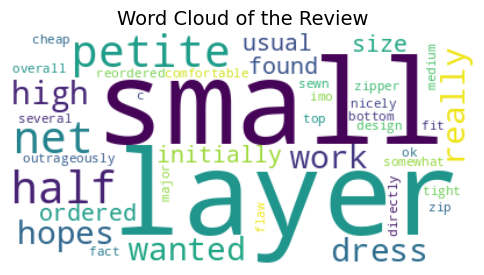

<ipython-input-36-e5ffcb2740f0>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="Blues_r")


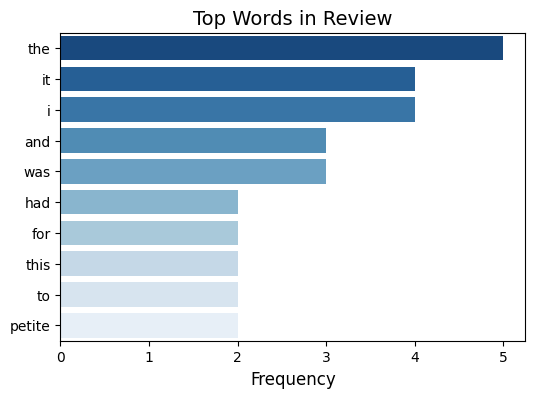


[Info] Sentiment for ID 1077: Neutral


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load the dataset
df = pd.read_csv("sentiment_predictions.csv")

# Input: Select an ID for analysis
selected_id = 1077  # Change this to the desired ID

# Filter the dataset for the specific ID
df_single = df[df["ID"] == selected_id]

# Check if the ID exists
if df_single.empty:
    print(f"[Error] No data found for ID: {selected_id}")
else:
    print(f"[Info] Analyzing Sentiment for ID: {selected_id}\n")

    # Display only available columns
    available_columns = df_single.columns.intersection(["ID", "Review Text", "Sentiment", "Negative Score", "Neutral Score", "Positive Score"])
    print(df_single[available_columns.tolist()])

    ### Display Top 20 Unique Reviews ###
    if "Review Text" in df.columns:
        unique_reviews = df["Review Text"].dropna().unique()[:20]
        print("\n[Info] Top 20 Unique Reviews:")
        for i, review in enumerate(unique_reviews, 1):
            print(f"{i}. {review}")
    else:
        print("[Warning] 'Review Text' column not found. Cannot display unique reviews.")

    ### Sentiment Score Visualization ###
    plt.figure(figsize=(6, 4))

    # Check if sentiment score columns exist
    score_columns = ["Negative Score", "Neutral Score", "Positive Score"]
    if all(col in df_single.columns for col in score_columns):
        scores = df_single.iloc[0][score_columns].values
        labels = score_columns
        colors = ["red", "gray", "green"]

        plt.bar(labels, scores, color=colors)
        plt.title(f"Sentiment Score for ID: {selected_id}", fontsize=14)
        plt.ylabel("Score")
        plt.show()
    else:
        print("[Warning] Sentiment score columns not found. Skipping visualization.")

    ### Word Cloud for Single Review ###
    review_text = df_single["Review Text"].values[0] if "Review Text" in df_single.columns and not df_single["Review Text"].isna().values[0] else ""

    if review_text:
        plt.figure(figsize=(6, 4))
        wordcloud = WordCloud(width=400, height=200, background_color="white").generate(review_text.lower())
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud of the Review", fontsize=14)
        plt.show()
    else:
        print("[Warning] No review text available for word cloud.")

    ### Most Frequent Words ###
    if review_text:
        words = Counter(review_text.split())
        top_words = dict(words.most_common(10))

        plt.figure(figsize=(6, 4))
        sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="Blues_r")
        plt.title("Top Words in Review", fontsize=14)
        plt.xlabel("Frequency", fontsize=12)
        plt.show()
    else:
        print("[Warning] No review text available for word frequency analysis.")

    ### Sentiment Summary ###
    sentiment = df_single["Sentiment"].values[0] if "Sentiment" in df_single.columns else "Unknown"
    print(f"\n[Info] Sentiment for ID {selected_id}: {sentiment}")


# **ChatBot**

In [ ]:
##############CHAT BOT#######

In [ ]:
pip install --upgrade google-generativeai


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install nltk gradio textblob google-generativeai


In [ ]:
!pip uninstall google-generativeai -y
!pip install --upgrade google-generativeai


Found existing installation: google-generativeai 0.8.4
Uninstalling google-generativeai-0.8.4:
  Successfully uninstalled google-generativeai-0.8.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install transformers sentencepiece torch gradio textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import nltk
import gradio as gr
from textblob import TextBlob
from transformers import pipeline

# Load a smaller, faster text generation model (GPT-2 Medium)
generator = pipeline("text-generation", model="gpt2-medium")

# Ensure necessary NLP data is downloaded
nltk.download('punkt')

# Function to generate meaningful suggestions
def generate_suggestion(sentiment, text):
    prompt = (
        f"The sentiment of the following text is {sentiment}. "
        f"Provide a helpful suggestion to improve the situation.\n\n"
        f"Text: {text}\n\n"
        f"Suggestion:"
    )

    try:
        response = generator(prompt, max_length=100, num_return_sequences=1)
        suggestion = response[0]["generated_text"].split("Suggestion:")[-1].strip()

        # If the model repeats the input text, return a default response
        if suggestion.lower() == text.lower():
            return "Try addressing the issues mentioned or finding alternatives."

        return suggestion

    except Exception as e:
        return f"Could not generate a suggestion due to an error: {e}"

# Function to analyze sentiment and provide suggestions
def analyze_sentiment_with_suggestions(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    sentiment = "Positive" if polarity > 0 else "Negative" if polarity < 0 else "Neutral"

    suggestion = generate_suggestion(sentiment, text)

    explanation = (
        f"**Sentiment:** {sentiment}\n"
        f"**Polarity:** {polarity:.2f}\n"
        f"**Suggestion:** {suggestion}"
    )
    return explanation

# Create Gradio UI
interface = gr.Interface(
    fn=analyze_sentiment_with_suggestions,
    inputs=gr.Textbox(lines=3, placeholder="Enter text here..."),
    outputs=gr.Markdown(),
    title="Sentiment Analysis with AI Suggestions",
    description="Enter any text, and the chatbot will analyze its sentiment and provide AI-powered suggestions."
)

# Launch Gradio app
interface.launch(share=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://271f9a6832f4d6ae2f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
